<a href="https://colab.research.google.com/github/Himanshu-kashyap/Pytorch-Tutorials/blob/master/3.1%20RNN_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## generating random data and predicting 

In [0]:
import torch
from torch import nn 
import numpy as np
import matplotlib.pyplot as plt

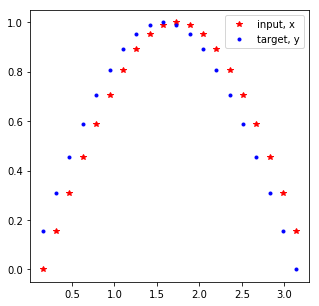

In [29]:
# generating random data
## y is basically x, shifted 1 timestep into the future


seq_size = 20 # batch size to take at a time to train from 

#generate evenly spaced data points

time_steps = np.linspace(0,np.pi,seq_size+1)  # generating numbers from 0 to pi
data = np.sin(time_steps)
data.resize((seq_size+1,1))

x = data[:-1]
y = data[1:]

#print the data
plt.figure(figsize =(5,5))
plt.plot(time_steps[1:], x, 'r*', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc = 'best')
plt.show()



## define the class

In [0]:
# torch.rnn defines an hidden state ht = tanh(wx+wh+b)

# takes in input and initial hidden state: 
# returns output and new hidden state
'''
input_size - the size of the input
hidden_dim - the number of features in the RNN output and in the hidden state
n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)
'''

class RNN(nn.Module):
  def __init__(self,input_size,output_size,hidden_dim,n_layers):
    super(RNN,self).__init__()
    
    self.hidden_dim = hidden_dim                                             # saving it in a var to use in forward pass function
    self.rnn = nn.RNN(input_size,hidden_dim,n_layers,batch_first = True)     # defining a rnn; batch_first = true means 1st arg will be batch size
    
    self.fc = nn.Linear(hidden_dim,output_size)                              # defining a fully connected layer to predict outputs take input as hidden dim 
    
  def forward(self,x,hidden):
    
    # x(batch_size,seq_length,input_size)
    # hidden(n_layers,batch_size,hidden_dim)
    # r_out(batch_size,time_step, hidden_size)
    
    
    batch_size = x.size(0)   # batch size is the size of batches in which training data will be taken
    
    r_out, hidden = self.rnn(x,hidden)
    r_out = r_out.view(-1,self.hidden_dim)  # this shape would be (batch_size*seq_length, hidden_dim)
    
    output = self.fc(r_out)  # final output  -- to fully connected layer
    
    return output,hidden
    
     
  

## test the inputs

In [35]:
test_rnn = RNN(input_size = 1, output_size = 1, hidden_dim = 10,n_layers = 2)

timesteps = np.linspace(0,np.pi,20)
test_data = np.sin(timesteps)

test_data.resize((20,1))

test_input = torch.Tensor(test_data).unsqueeze(0)
print("\ninput size\n", test_input.size())


test_out,test_h = test_rnn(test_input,None)
print("output_size",test_out.size(),"\n hidden state size",test_h.size())



input size
 torch.Size([1, 20, 1])
output_size torch.Size([20, 1]) 
 hidden state size torch.Size([2, 1, 10])


## Training the Model

In [36]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

rnn = RNN(input_size,output_size,hidden_dim,n_layers)
print(rnn)


RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Loss and Optimization


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.01)


## Training function definiton

In [0]:
def train(rnn,n_steps,print_every):
    
    
    seq_length = 20
    hidden = None
    
    for batch_i,step in enumerate(range(n_steps)):
      # create data
      timesteps = np.linspace(step*np.pi,(step+1)*np.pi,seq_length+1)
      data = np.sin(timesteps)
      data.resize((seq_length+1,1)) #input size = 1
      
      
      x = data[:-1]
      y = data[1:]
      
      # convert data into tensors
      x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a [1,batchsize] 
      y_tensor = torch.Tensor(y)
      
      #outputs from rnn
      prediction,hidden = rnn(x_tensor,hidden)
      
      # representing memory
      # detach hidden from it's history by making a new variable everytime, we dont take whole history this way
      
      hidden = hidden.data
      
      loss = criterion(prediction,y_tensor)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if batch_i % print_every == 0:
        print("LOSS :" ,loss.item())
        plt.plot(timesteps[1:],x,'r*')  # input
        plt.plot(timesteps[1:],prediction.data.numpy().flatten(),'b.') #predictions
        plt.show()
        
    return rnn   

LOSS : 0.6338561773300171


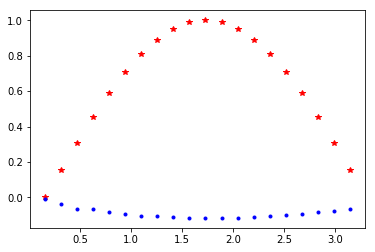

LOSS : 0.036401886492967606


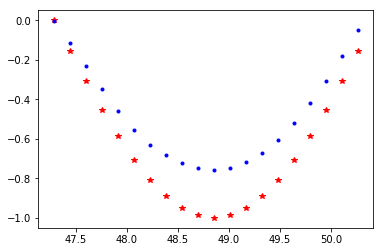

LOSS : 0.003928148653358221


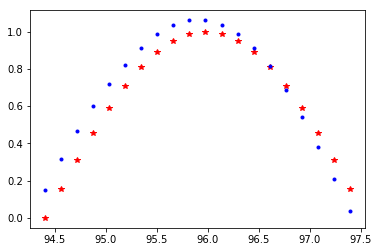

LOSS : 0.00037121507921256125


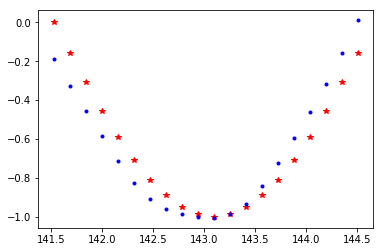

LOSS : 0.0015759022207930684


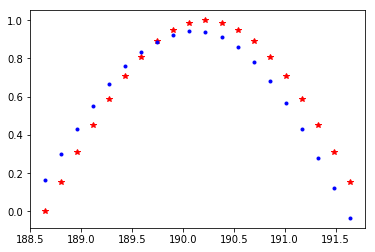

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [39]:
n_steps = 75
print_every = 15

train(rnn,n_steps,print_every)